## Unsupervised Learning Trading Strategy 
- download SP500 stocks prices data
- calculate different features and indicators on each stock
- aggregate on monthly level and filter top 150 most liquid stocks
- calculate monthly returns for different time-horizons
- download fama-french factors and calculate rolling factor betas
- for each month fit a k-means clustering algorithm to group similar assets based on their features
- for each month select assets based on the cluster and form a portfolio based on Efficience Frontier max sharpe ratio optimization
- visualize portfolio returns and compre to sp500 returns 

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import ssl
import certifi
import urllib.request

warnings.filterwarnings('ignore')

# Create an SSL context using certifi's CA Bundle
ssl_context = ssl.create_default_context(cafile=certifi.where())

# Read HTML content using urllib with the created SSL context
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = urllib.request.urlopen(url, context=ssl_context)
html = response.read()

# Parse the HTML content with pandas
sp500 = pd.read_html(html)
sp500 = sp500[0]

# Format the ticker symbols
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Define the date range
end_date = '2024-07-08'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download the stock data
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names=['date','ticker']

df.columns = df.columns.str.lower()
df

[*********************100%%**********************]  503 of 503 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1468123200, endDate = 1720411200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-11 A        42.635674   45.400002   45.770000   45.349998   45.610001   
           AAL      29.945486   31.160000   31.440001   30.219999   30.230000   
           AAPL     22.268705   24.245001   24.412500   24.182501   24.187500   
           ABBV     45.188736   64.349998   64.989998   64.070000   64.250000   
           ABT      36.162102   42.119999   42.310001   42.000000   42.029999   
...                       ...         ...         ...         ...         ...   
2024-07-05 XYL     134.259995  134.259995  134.300003  131.119995  132.550003   
           YUM     129.119995  129.119995  129.690002  128.229996  129.320007   
           ZBH     108.010002  108.010002  108.160004  106.169998  106.820000   
           ZBRA    310.510010  310.510010  312.429993  308.700012  312.250000   
           ZTS     174.544830  174.960007  175.960007  174.250000  175.199997   

Price                  volume  
date       ticker              
2016-07-11 A        1094700.0  
           AAL     12374400.0  
           AAPL    95179600.0  
           ABBV     9641500.0  
           ABT      9052300.0  
...                       ...  
2024-07-05 XYL      1106300.0  
           YUM      1477600.0  
           ZBH      1045000.0  
           ZBRA      245700.0  
           ZTS      1812100.0  

[989406 rows x 6 columns]

## Calculate Features and technical indicators for each stock 
- garman-klass volatility
- RSI
- bollinger bands
- ATR
- MACD
- dollar volume

In [29]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-11 A        42.635670   45.400002   45.770000   45.349998   45.610001   
           AAL      29.945486   31.160000   31.440001   30.219999   30.230000   
           AAPL     22.268715   24.245001   24.412500   24.182501   24.187500   
           ABBV     45.188725   64.349998   64.989998   64.070000   64.250000   
           ABT      36.162102   42.119999   42.310001   42.000000   42.029999   
...                       ...         ...         ...         ...         ...   
2024-07-05 XYL     134.259995  134.259995  134.300003  131.119995  132.550003   
           YUM     129.119995  129.119995  129.690002  128.229996  129.320007   
           ZBH     108.010002  108.010002  108.160004  106.169998  106.820000   
           ZBRA    310.510010  310.510010  312.429993  308.700012  312.250000   
           ZTS     174.544830  174.960007  175.960007  174.250000  175.199997   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-07-11 A        1094700.0         -0.001714        NaN       NaN   
           AAL     12374400.0          0.000749        NaN       NaN   
           AAPL    95179600.0         -0.002594        NaN       NaN   
           ABBV     9641500.0         -0.047744        NaN       NaN   
           ABT      9052300.0         -0.008708        NaN       NaN   
...                       ...               ...        ...       ...   
2024-07-05 XYL      1106300.0          0.000224  45.011493  4.889272   
           YUM      1477600.0          0.000063  34.055505  4.858185   
           ZBH      1045000.0          0.000125  38.410755  4.653470   
           ZBRA      245700.0          0.000060  53.177470  5.693120   
           ZTS      1812100.0          0.000042  54.566067  5.121551   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-11 A            NaN       NaN       NaN       NaN      46.673268  
           AAL          NaN       NaN       NaN       NaN     370.557423  
           AAPL         NaN       NaN       NaN       NaN    2119.527377  
           ABBV         NaN       NaN       NaN       NaN     435.687087  
           ABT          NaN       NaN       NaN       NaN     327.350194  
...                     ...       ...       ...       ...            ...  
2024-07-05 XYL     4.928299  4.967326  0.838965 -1.072214     148.531832  
           YUM     4.908755  4.959325  0.139003 -1.728277     190.787705  
           ZBH     4.692822  4.732174 -0.807169 -0.890284     112.870452  
           ZBRA    5.722956  5.752792 -0.299779 -0.070548      76.292309  
           ZTS     5.158563  5.195575  0.705350  0.236772     316.292687  

[989406 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks for each month
- to reduce training time and experiment with features and strategies, we convert the business daily data to month-end frequency

In [30]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-08-31 A           87.662069   44.119473         -0.001640  49.171254   
           AAL        269.710268   34.989563         -0.000479  57.613196   
           AAPL      2718.975523   24.494843         -0.002162  56.336554   
           ABBV       306.400108   45.408314         -0.046259  39.550009   
           ABT        375.329248   36.298470         -0.010390  34.489702   
...                          ...         ...               ...        ...   
2024-07-31 GEHC       158.674916   77.031448          0.000040  43.994437   
           KVUE       244.587424   18.309999          0.000048  43.853663   
           VLTO       135.537247   95.599998          0.000122  44.493225   
           GEV        347.648082  176.229996          0.000342  55.811074   
           SOLV        71.421093   49.900002          0.000373  31.035559   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-08-31 A       3.799092  3.820731  3.842369 -1.375168 -0.132273  
           AAL     3.511263  3.567882  3.624501  0.000410  0.563001  
           AAPL    3.235305  3.255475  3.275645 -1.325390 -0.116317  
           ABBV    3.835019  3.867038  3.899057 -1.522259 -0.278335  
           ABT     3.624830  3.667518  3.710207 -1.202059 -0.311407  
...                     ...       ...       ...       ...       ...  
2024-07-31 GEHC    4.328717  4.360711  4.392706 -0.942918 -0.595581  
           KVUE    2.936864  2.965352  2.993840 -0.973624 -0.200413  
           VLTO    4.557449  4.600882  4.644316 -0.655006 -1.806821  
           GEV     5.089717  5.157332  5.224946 -0.384884 -1.371641  
           SOLV    3.914520  3.992807  4.071095 -1.481290 -0.897731  

[47256 rows x 9 columns]

- calculate 5-year rolling average of dollar volume for each stocks before filtering 

In [31]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-07-31 AAL      48.955452         -0.000281  49.738410  3.892343   
           AAPL     34.805630         -0.002001  50.672262  3.533293   
           ABBV     51.445614         -0.038363  45.182743  3.959512   
           ABT      43.532562         -0.006503  55.959058  3.753880   
           ACN     115.462814         -0.004393  60.835358  4.707508   
...                       ...               ...        ...       ...   
2024-07-31 MRNA    118.320000          0.000339  40.351547  4.710021   
           UBER     71.059998          0.000106  53.943789  4.241062   
           CRWD    389.679993          0.000117  61.714480  5.874645   
           ABNB    152.500000          0.000045  53.636013  4.982239   
           KVUE     18.309999          0.000048  43.853663  2.936864   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-07-31 AAL     3.941200  3.990058  0.802814  0.307245  
           AAPL    3.575070  3.616847 -1.155494 -0.181704  
           ABBV    3.990966  4.022419 -1.284225 -0.110873  
           ABT     3.796236  3.838591 -1.329833  0.295647  
           ACN     4.740108  4.772708 -1.252206  0.092274  
...                     ...       ...       ...       ...  
2024-07-31 MRNA    4.900366  5.090710 -0.164149 -0.738131  
           UBER    4.270789  4.300515  0.543618  0.548753  
           CRWD    5.944401  6.014157  1.208867  1.625272  
           ABNB    5.013459  5.044679 -1.225067  0.220430  
           KVUE    2.965352  2.993840 -0.973624 -0.200413  

[12665 rows x 8 columns]

## Calculate monthly returns for different time horizons as features
- to capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [32]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702709          0.000092  49.117686  3.591910   
           AAPL     45.223698         -0.000885  52.605343  3.808181   
           ABBV     70.257530         -0.027194  45.920935  4.225651   
           ABT      59.123020         -0.003867  62.882550  4.015925   
           ACN     145.464798         -0.003530  42.887812  4.993172   
...                       ...               ...        ...       ...   
2024-07-31 XOM     113.370003          0.000100  48.755326  4.695178   
           MRNA    118.320000          0.000339  40.351547  4.710021   
           UBER     71.059998          0.000106  53.943789  4.241062   
           CRWD    389.679993          0.000117  61.714480  5.874645   
           ABNB    152.500000          0.000045  53.636013  4.982239   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-07-31 AAL     3.645691  3.699472  0.798023 -0.291276   0.041623   
           AAPL    3.834322  3.860463 -1.078645 -0.167516   0.027984   
           ABBV    4.279128  4.332605  0.042747 -0.727231   0.005633   
           ABT     4.062819  4.109713 -0.944073  0.533089   0.079433   
           ACN     5.023605  5.054037 -0.839379 -0.173283  -0.026041   
...                     ...       ...       ...       ...        ...   
2024-07-31 XOM     4.732689  4.770199  0.453075 -0.106094  -0.015202   
           MRNA    4.900366  5.090710 -0.164149 -0.738131  -0.003621   
           UBER    4.270789  4.300515  0.543618  0.548753  -0.022290   
           CRWD    5.944401  6.014157  1.208867  1.625272   0.016937   
           ABNB    5.013459  5.044679 -1.225067  0.220430   0.005738   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-07-31 XOM     -0.016727  -0.011343   0.019371   0.010620    0.007545  
           MRNA    -0.088943   0.023641   0.026645   0.050475    0.000466  
           UBER     0.049134   0.023535   0.014266   0.056639    0.030657  
           CRWD     0.114596   0.100291   0.048972   0.091803    0.076074  
           ABNB     0.025784  -0.012926   0.009441   0.028627    0.000170  

[10506 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas
- we will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
- the five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- we can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression 

In [33]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0045  0.0155  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035   0.027984
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10364 rows x 6 columns]

- filter out stocks will less than 10 months of data 

In [34]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0045  0.0155  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035   0.027984
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10336 rows x 6 columns]

- calculate rolling factor betas

In [35]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.489479  0.498689 -0.378682  0.472388  0.418508
           VZ      0.646405 -1.233371  0.593769 -0.054422 -0.053089
           WFC     1.021367  0.344369  1.209067 -0.499866 -0.755414
           WMT     0.480751  0.179872 -0.134151  0.935791  0.005897
           XOM     0.742555  0.043685  0.430449  0.839551  0.497580

[10336 rows x 5 columns]

- join the rolling factors data to the main features dataframe

In [36]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10312 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10312 non-null  float64
 1   rsi               10312 non-null  float64
 2   bb_low            10312 non-null  float64
 3   bb_mid            10312 non-null  float64
 4   bb_high           10312 non-null  float64
 5   atr               10312 non-null  float64
 6   macd              10312 non-null  float64
 7   return_1m         10312 non-null  float64
 8   return_2m         10312 non-null  float64
 9   return_3m         10312 non-null  float64
 10  return_6m         10312 non-null  float64
 11  return_9m         10312 non-null  float64
 12  return_12m        10312 non-null  float64
 13  Mkt-RF            10312 non-null  float64
 14  SMB               10312 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions, etc. 

## For each month fit a K-Means Clustering Algorithm to group similar assets based on their features. 
### K-Means Clustering
- initialize predefined centroids for each cluster based on research

In [45]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117686  3.591910  3.645691  3.699472   
           AAPL           -0.000885  52.605343  3.808181  3.834322  3.860463   
           ABBV           -0.027194  45.920935  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882550  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887812  4.993172  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-07-31 WMT             0.000154  69.246723  4.201761  4.228002  4.254243   
           XOM             0.000100  48.755326  4.695178  4.732689  4.770199   
           MRNA            0.000339  40.351547  4.710021  4.900366  5.090710   
           UBER            0.000106  53.943789  4.241062  4.270789  4.300515   
           CRWD            0.000117  61.714480  5.874645  5.944401  6.014157   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.798023 -0.291276   0.041623  -0.047041  -0.026289   
           AAPL   -1.078645 -0.167516   0.027984   0.009109   0.049478   
           ABBV    0.042747 -0.727231   0.005633  -0.029587  -0.011801   
           ABT    -0.944073  0.533089   0.079433   0.034389   0.042361   
           ACN    -0.839379 -0.173283  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-07-31 WMT     1.353571  1.859305   0.034411   0.032030   0.057975   
           XOM     0.453075 -0.106094  -0.015202  -0.016727  -0.011343   
           MRNA   -0.164149 -0.738131  -0.003621  -0.088943   0.023641   
           UBER    0.543618  0.548753  -0.022290   0.049134   0.023535   
           CRWD    1.208867  1.625272   0.016937   0.114596   0.100291   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.213959  1.513005   
           AAPL     0.022909   0.014540    0.022060  1.314183 -0.315317   
           ABBV    -0.028860   0.005495    0.026310  0.471209  0.507529   
           ABT      0.010427   0.022867    0.025837  0.788181 -0.135119   
           ACN      0.000037   0.013581    0.019435  1.212994 -0.192131   
...                      ...        ...         ...       ...       ...   
2024-07-31 WMT      0.042039   0.029537    0.024247  0.616307 -0.383711   
           XOM      0.019371   0.010620    0.007545  1.066419  0.131473   
           MRNA     0.026645   0.050475    0.000466  1.356406  0.813937   
           UBER     0.014266   0.056639    0.030657  1.208368  0.778254   
           CRWD     0.048972   0.091803    0.076074  0.576886 -1.260914   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.370547  0.178105  0.836323        3  
           AAPL   -0.626314  0.432607  0.605909        3  
           ABBV   -0.206893  0.544084  0.489800        0  
           ABT    -0.435130  0.223149  0.937489        1  
           ACN    -0.261593  0.324797  0.092279        0  
...                     ...       ...       ...      ...  
2024-07-31 WMT    -0.368528  0.221573  0.676837        1  
           XOM     0.845784 -0.468165  0.426275        3  
           MRNA   -1.004347  1.083125  1.038272        0  
           UBER   -0.386412 -1.716024 -0.350856        3  
           CRWD   -0.177770 -2.741235 -1.363178        2  

[10312 rows x 19 columns]

In [46]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

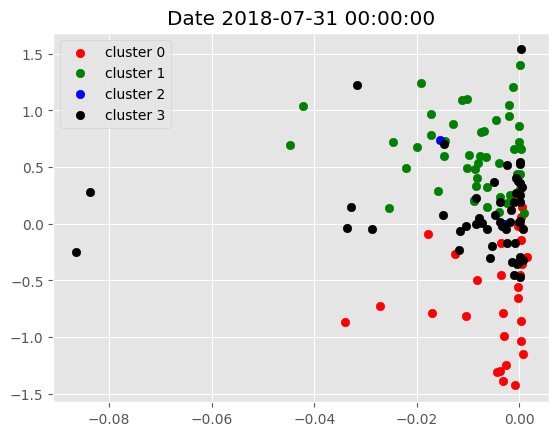

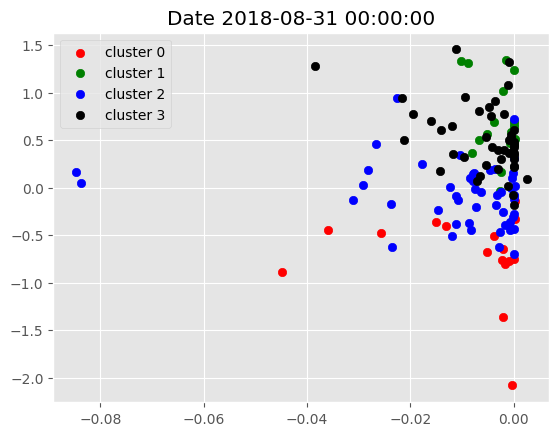

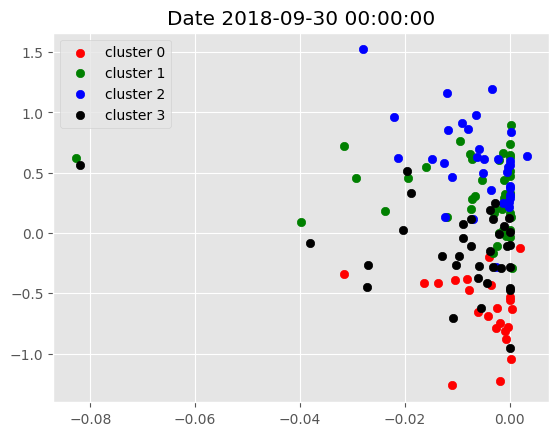

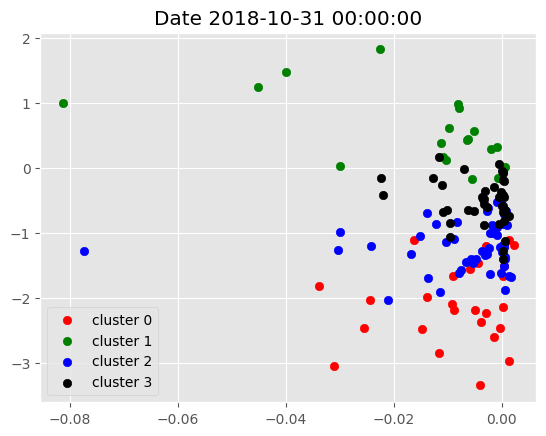

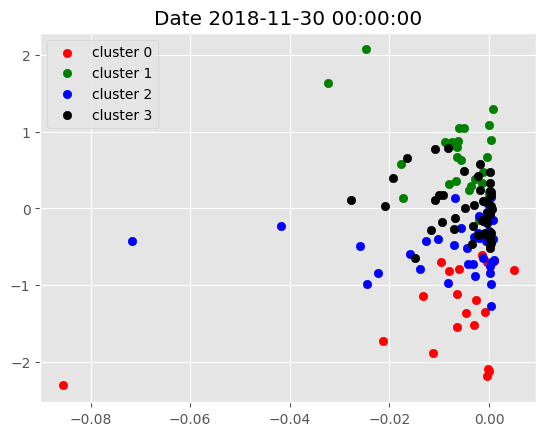

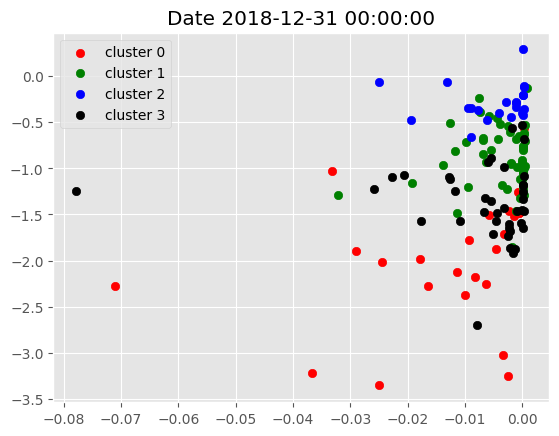

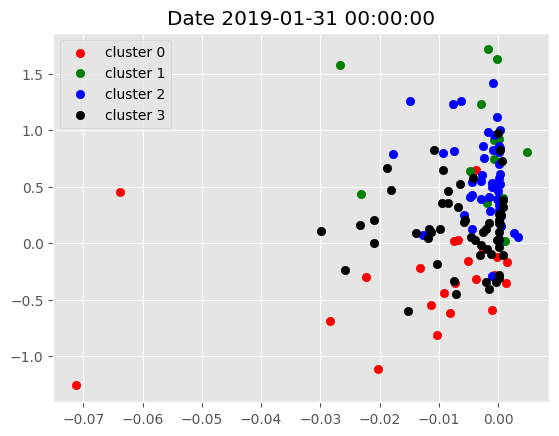

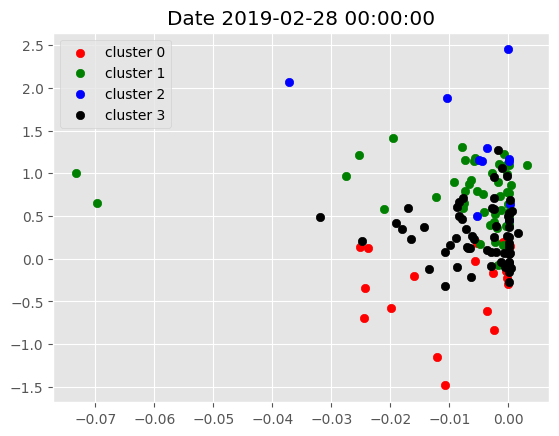

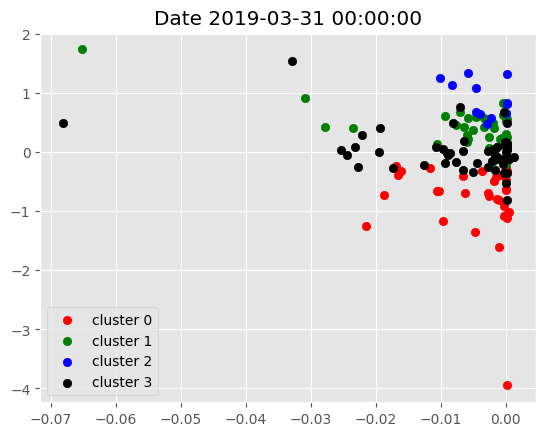

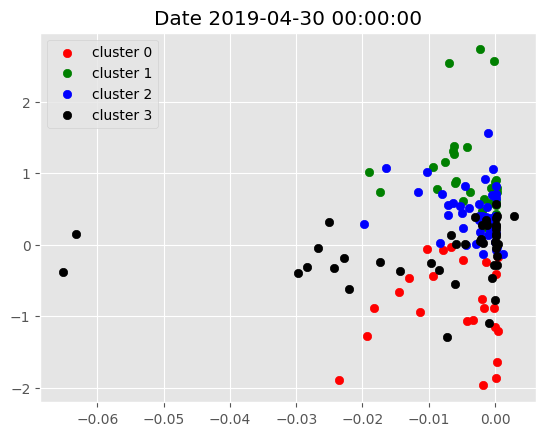

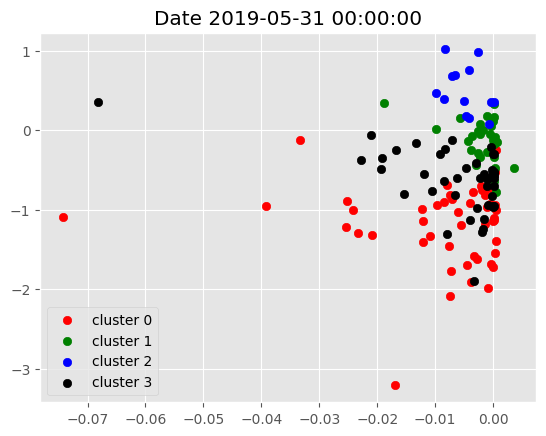

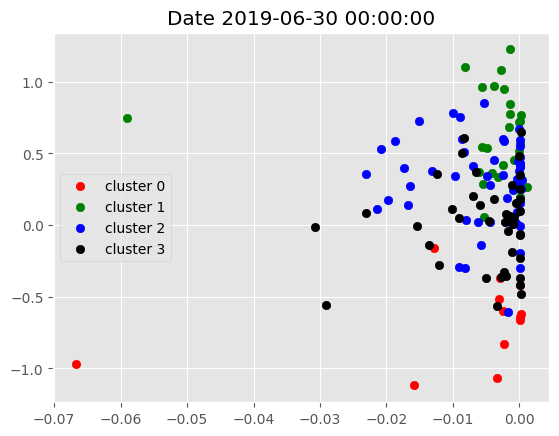

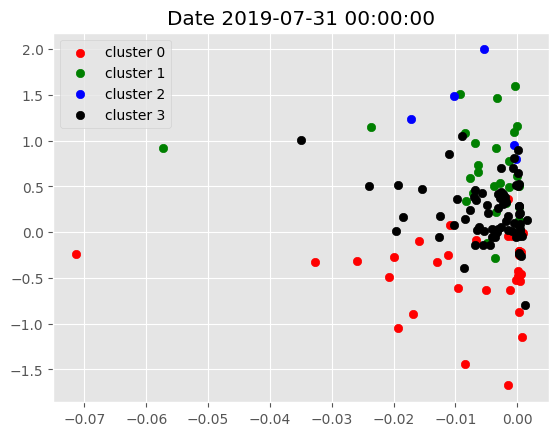

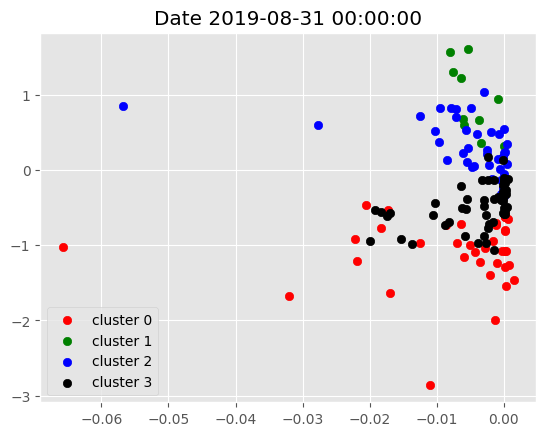

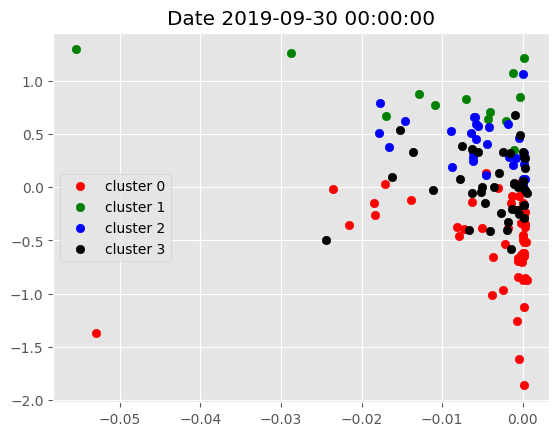

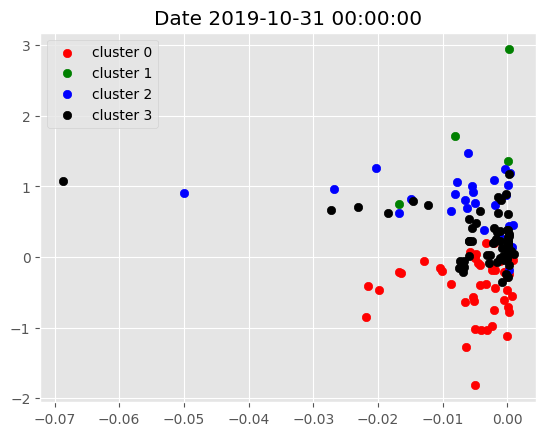

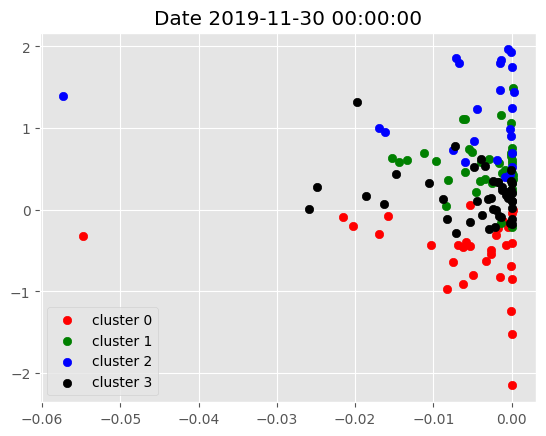

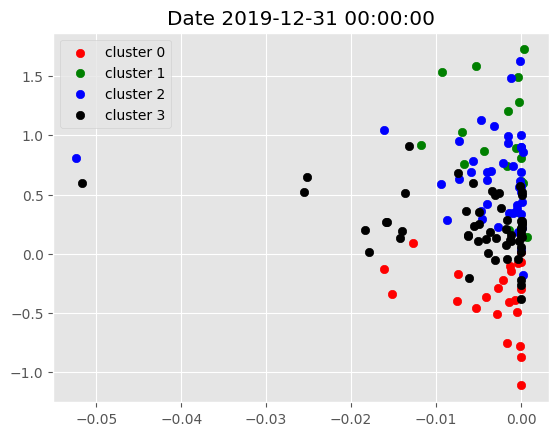

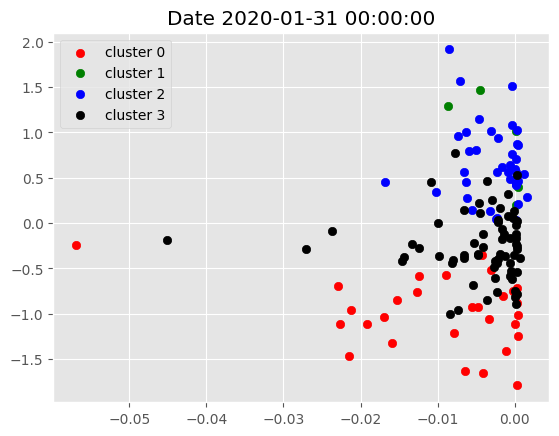

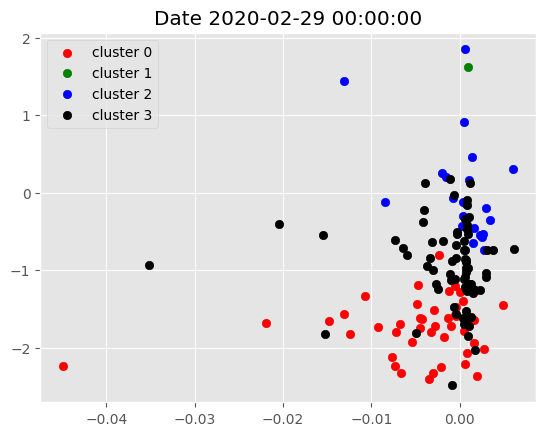

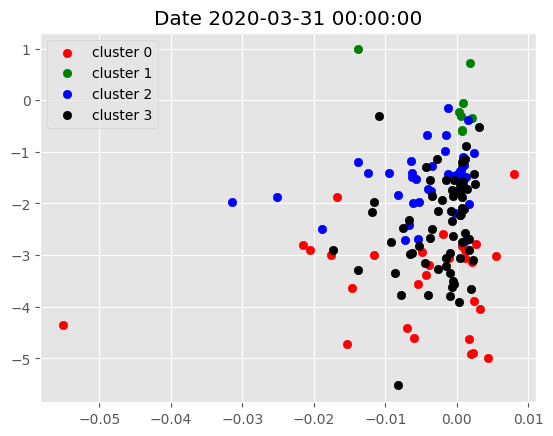

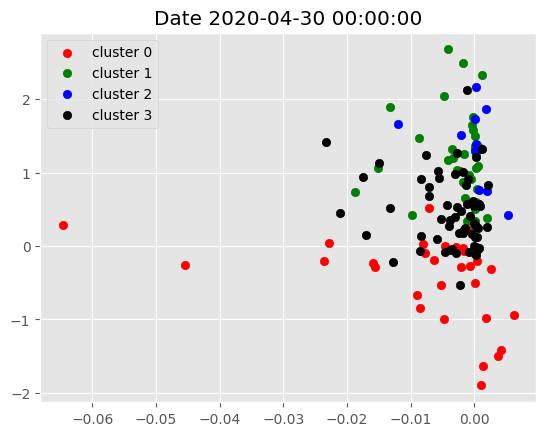

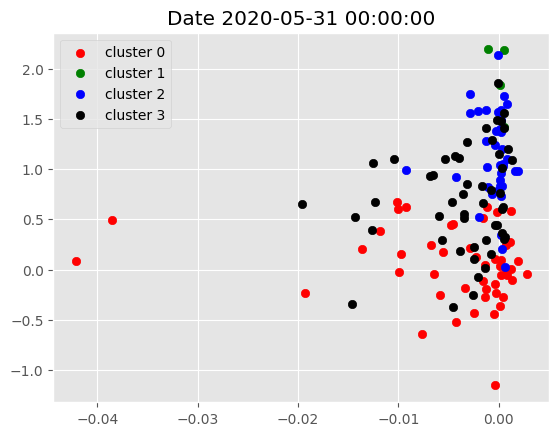

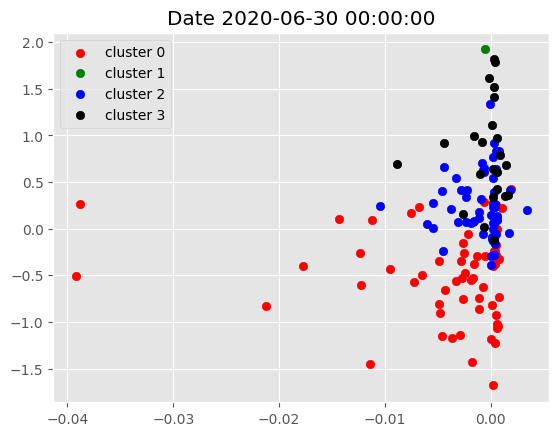

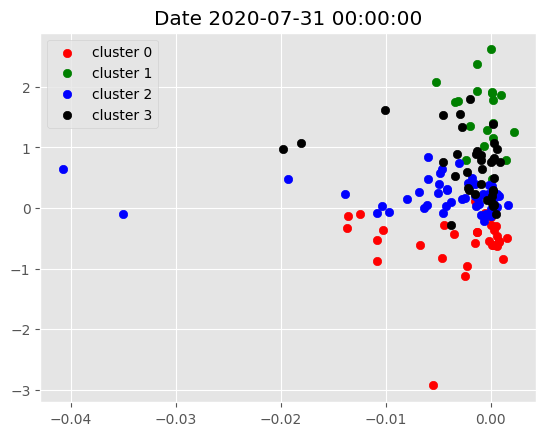

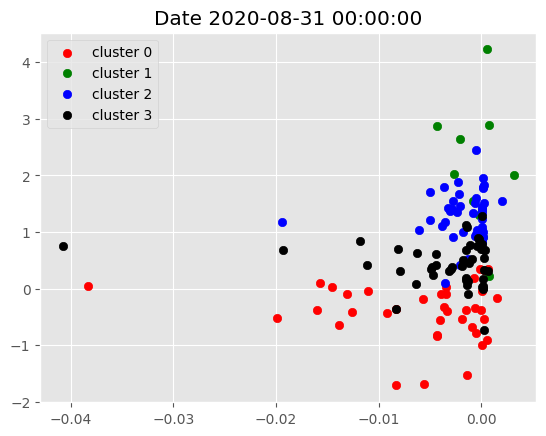

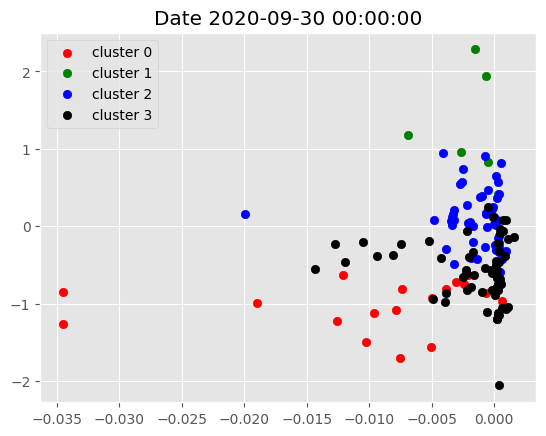

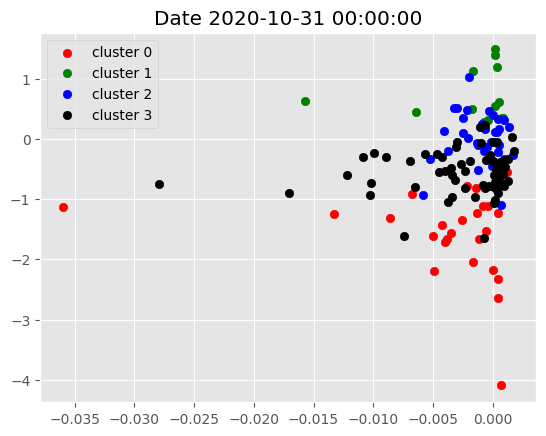

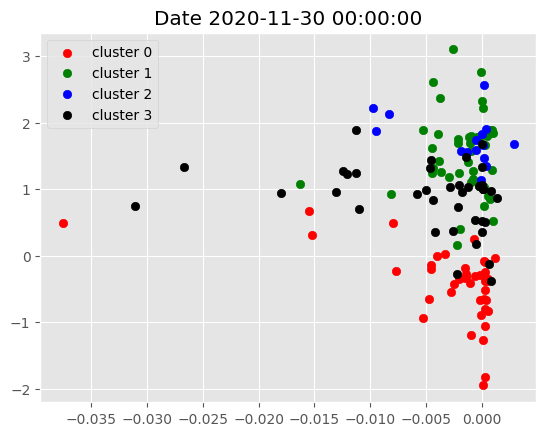

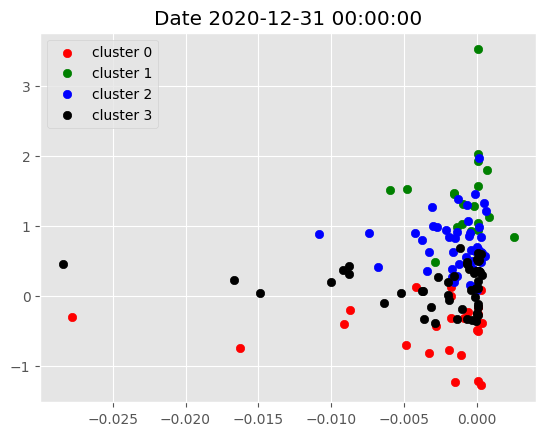

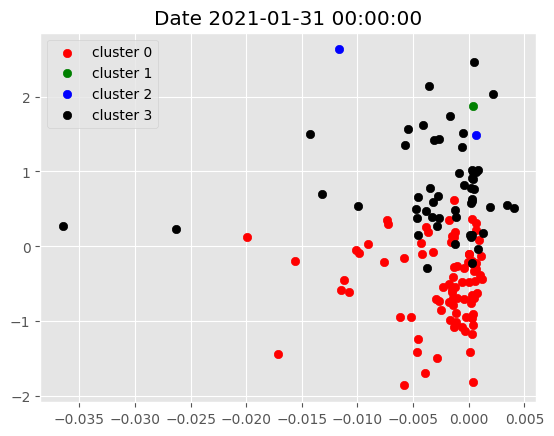

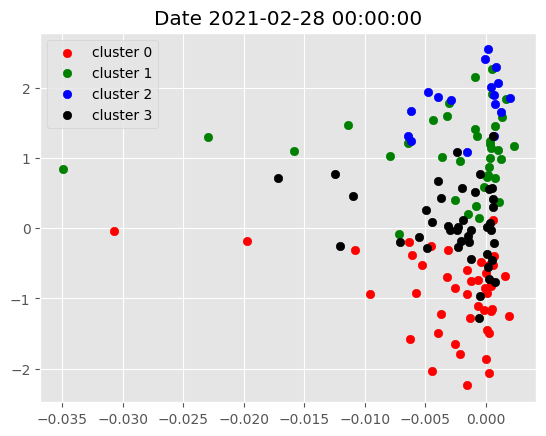

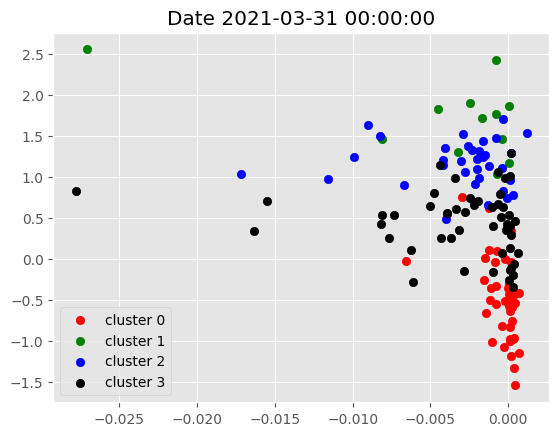

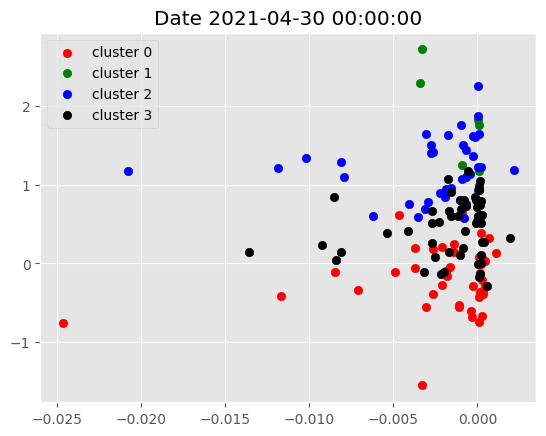

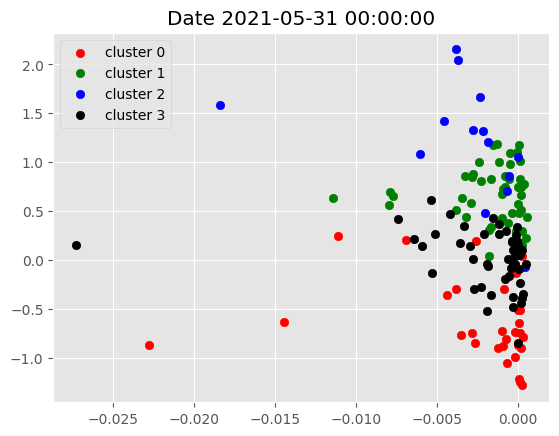

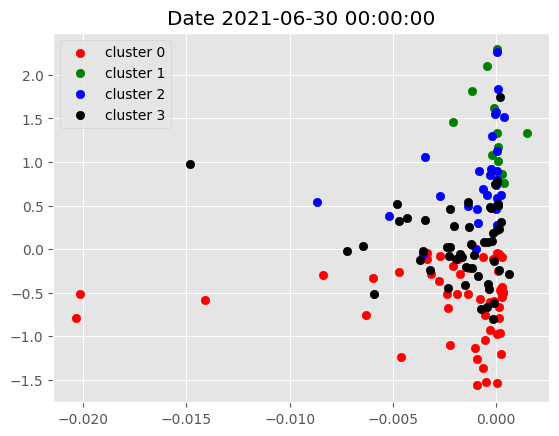

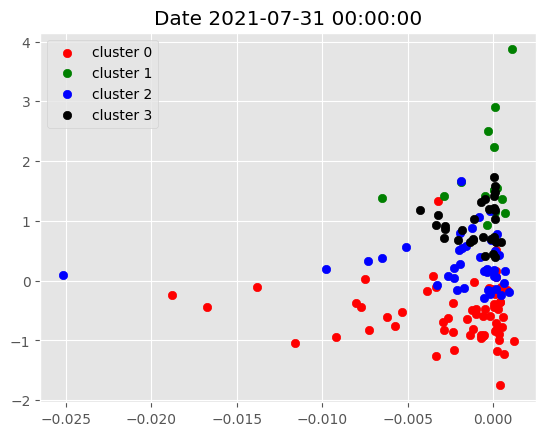

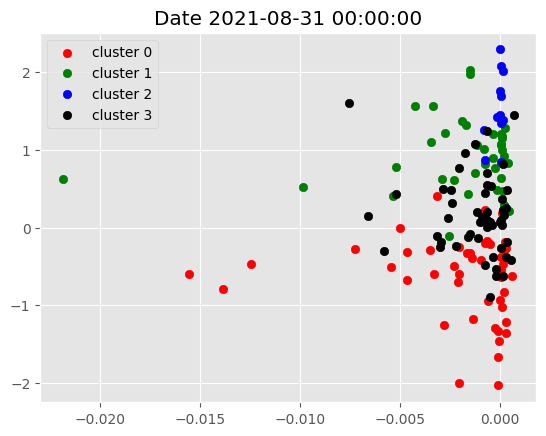

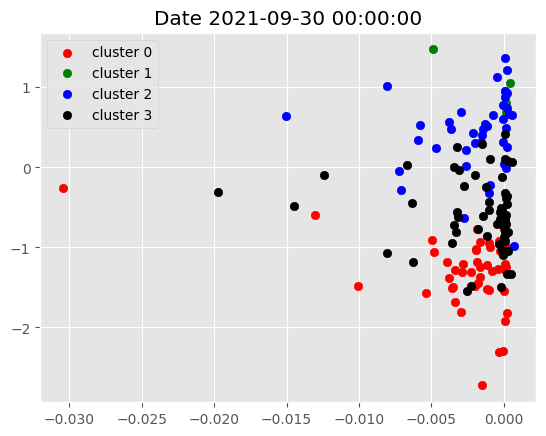

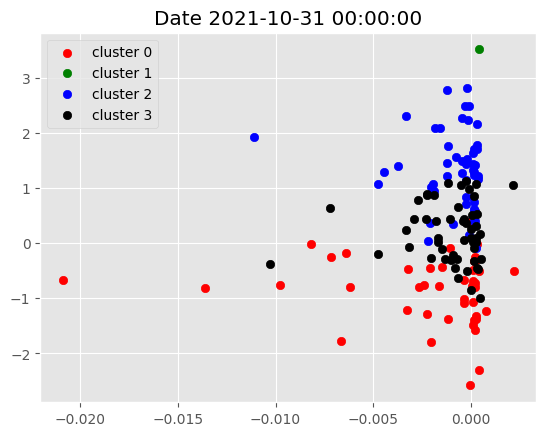

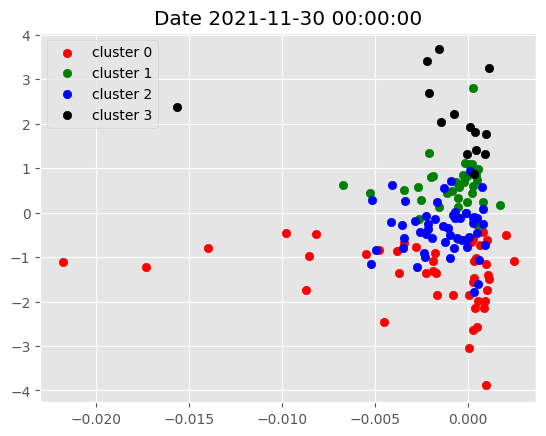

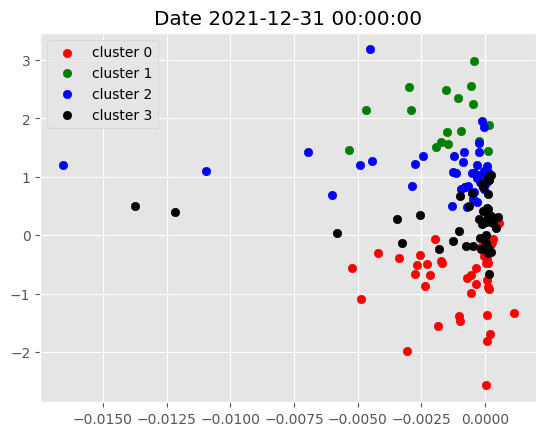

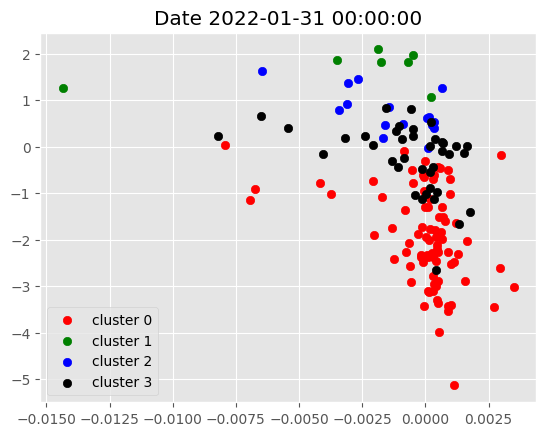

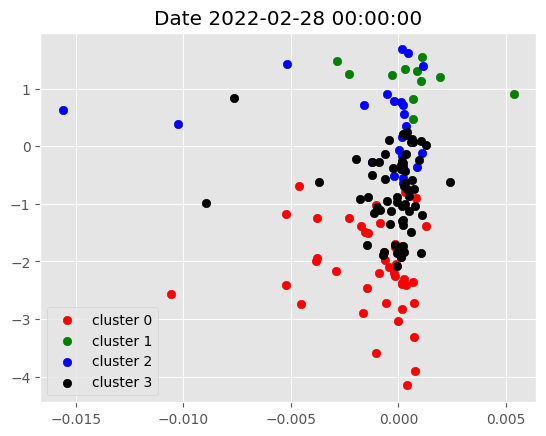

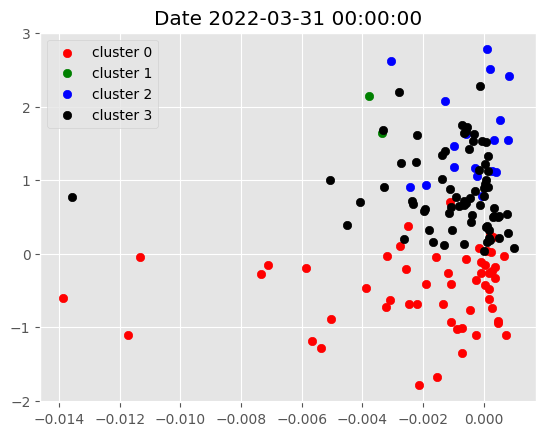

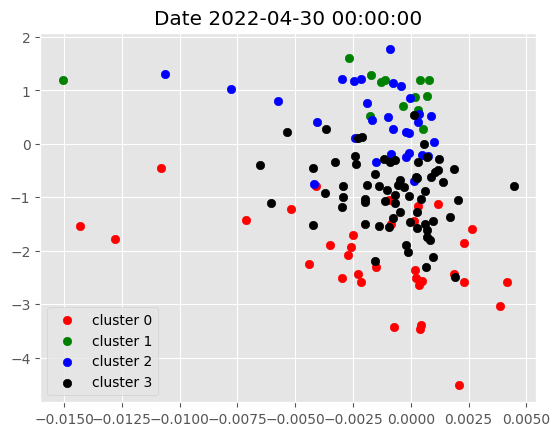

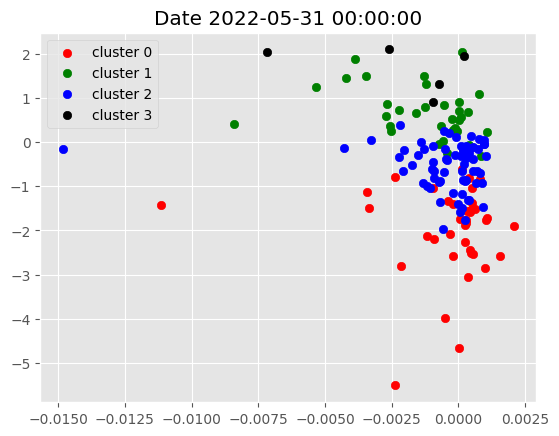

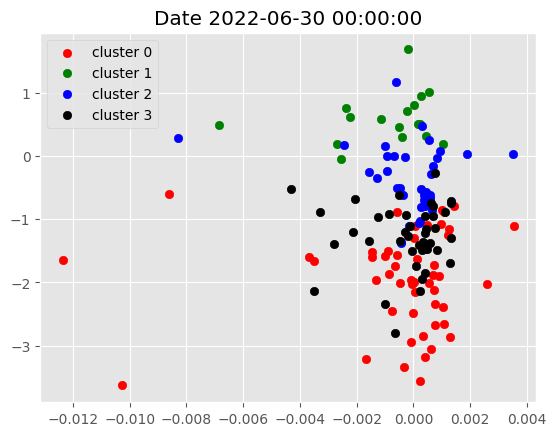

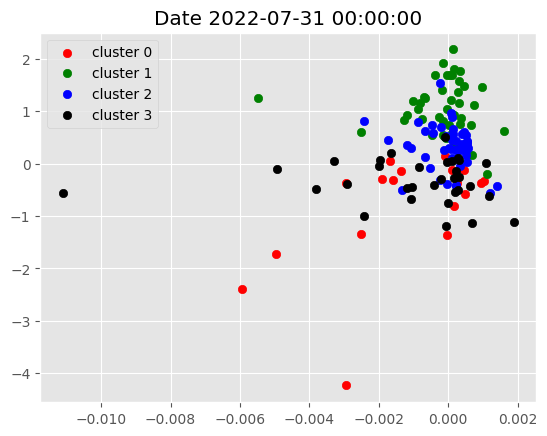

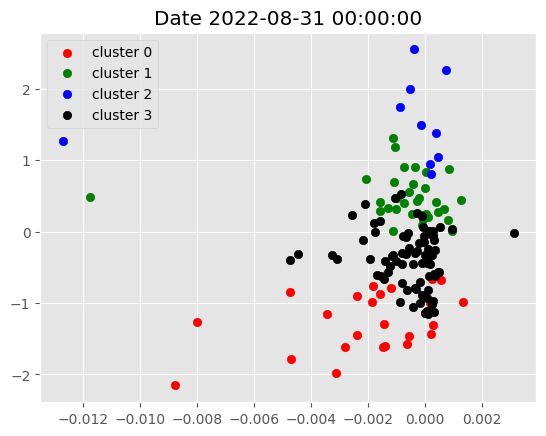

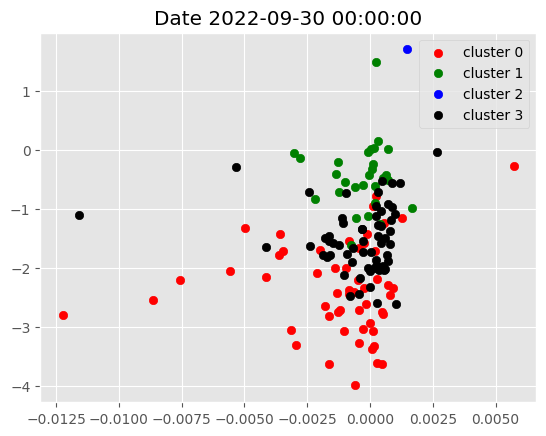

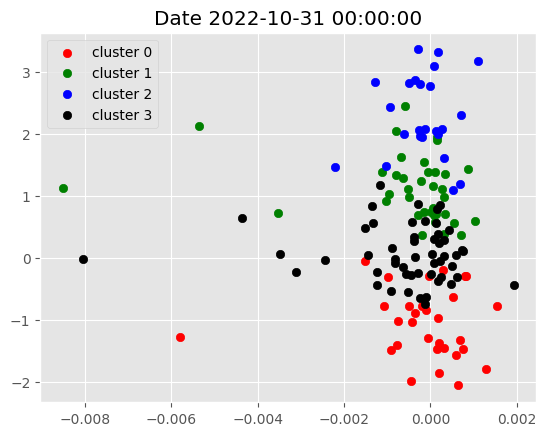

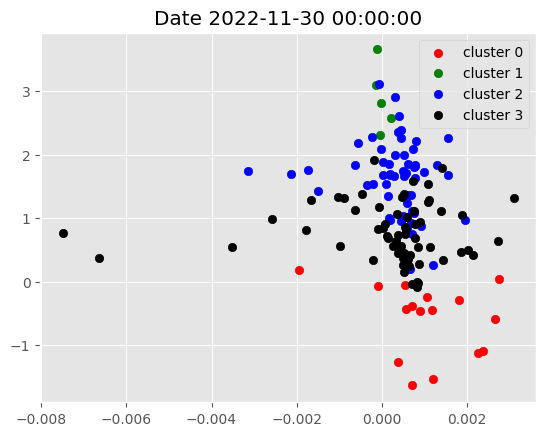

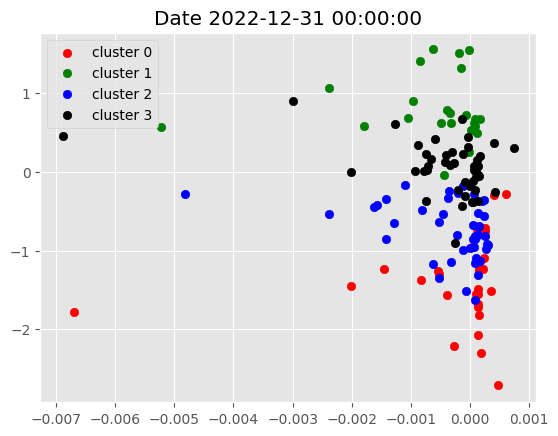

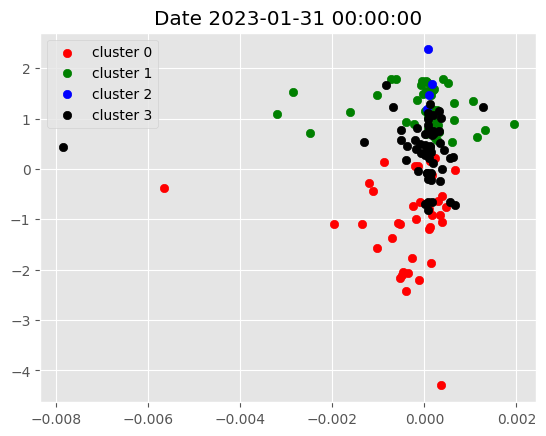

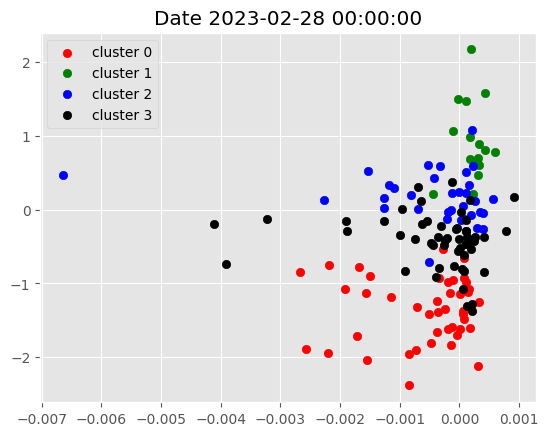

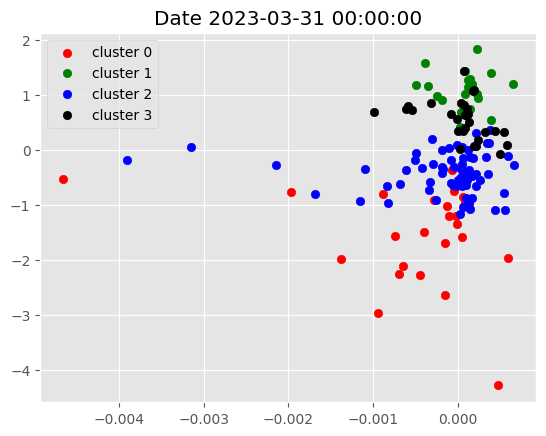

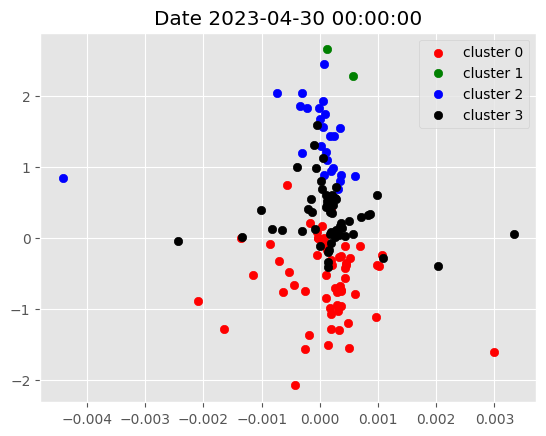

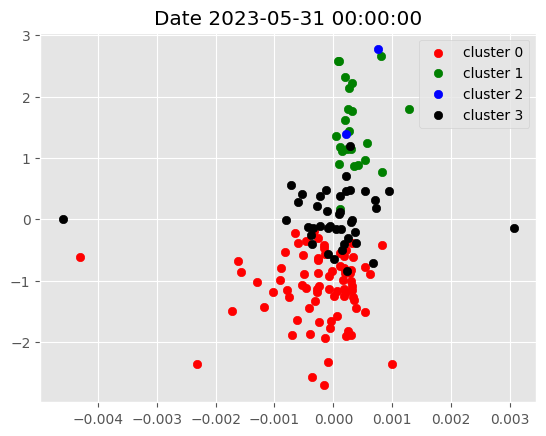

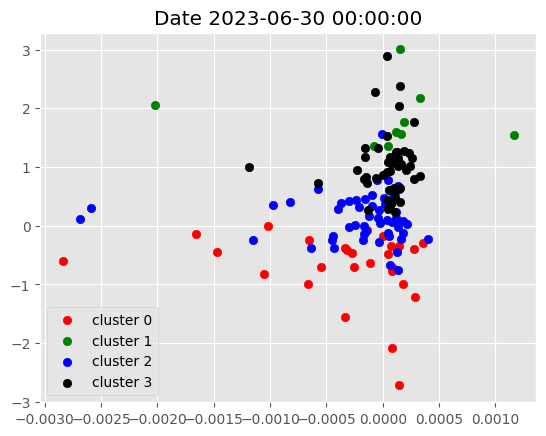

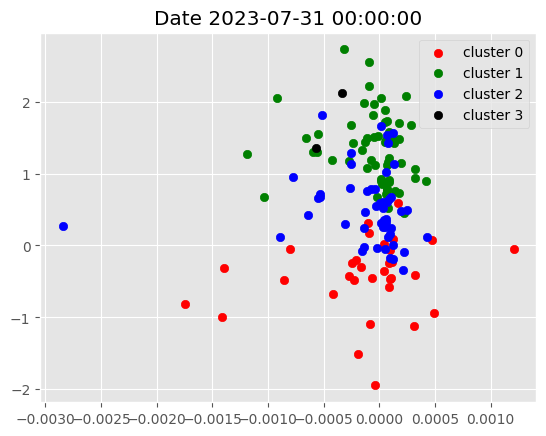

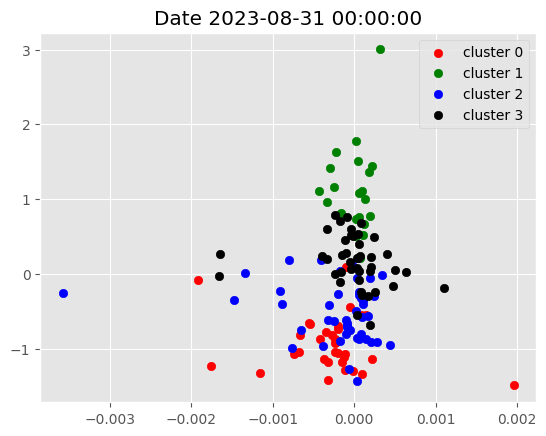

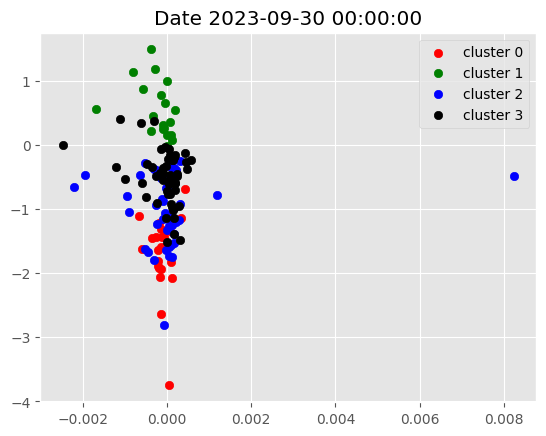

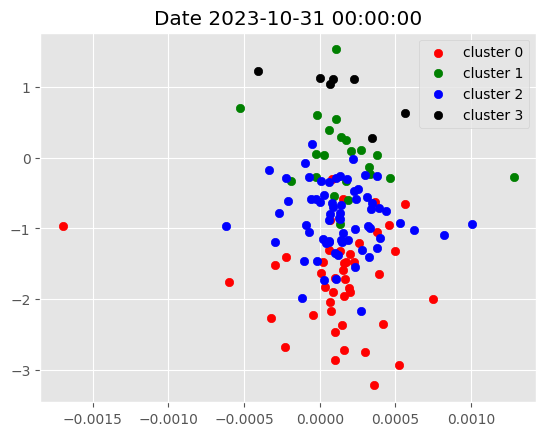

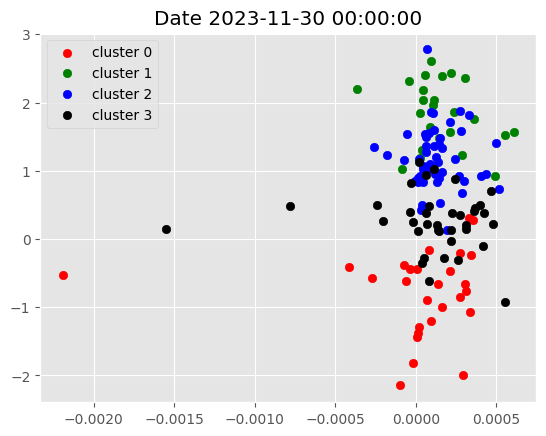

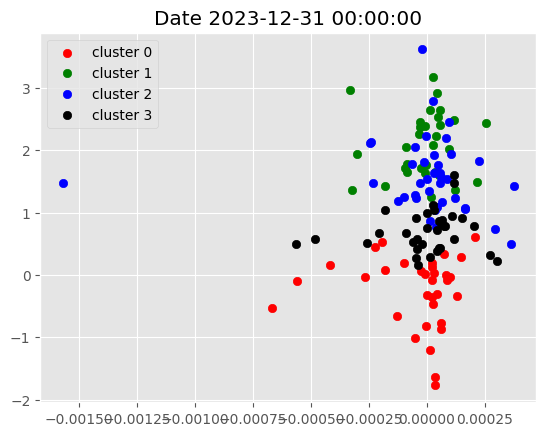

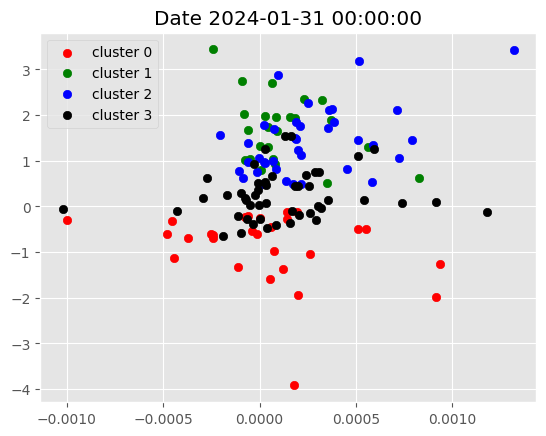

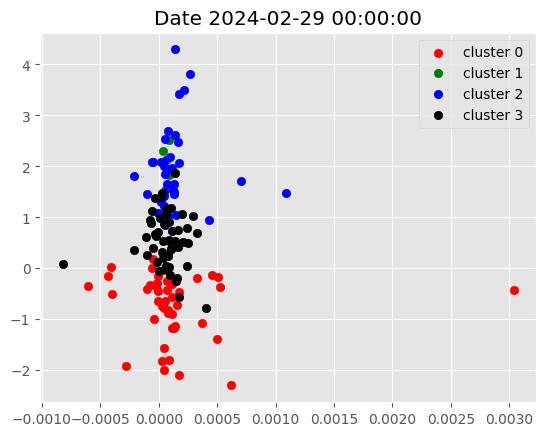

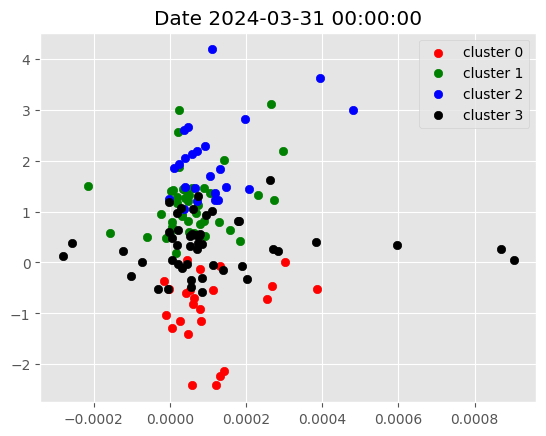

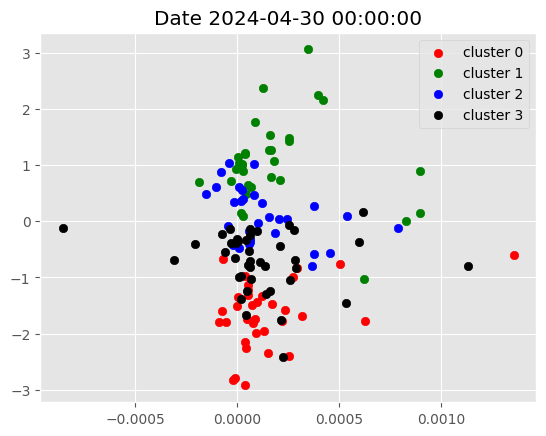

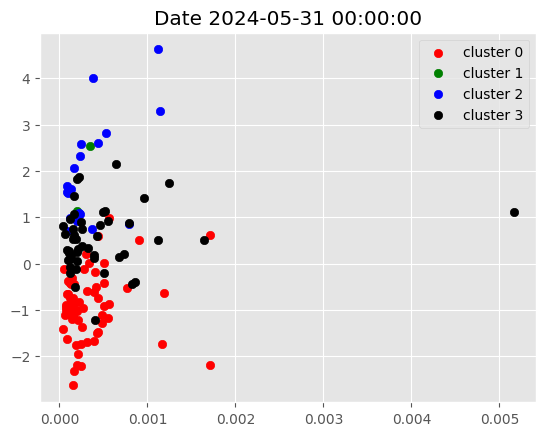

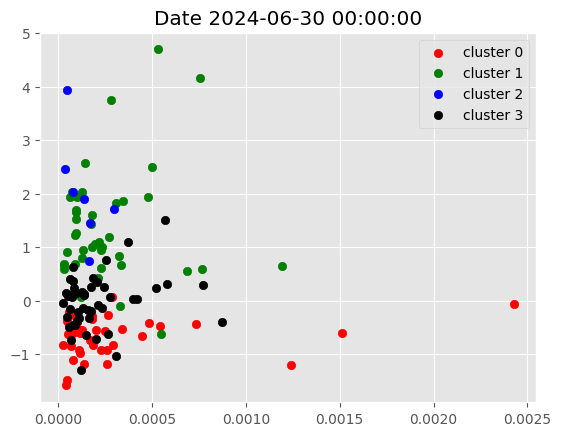

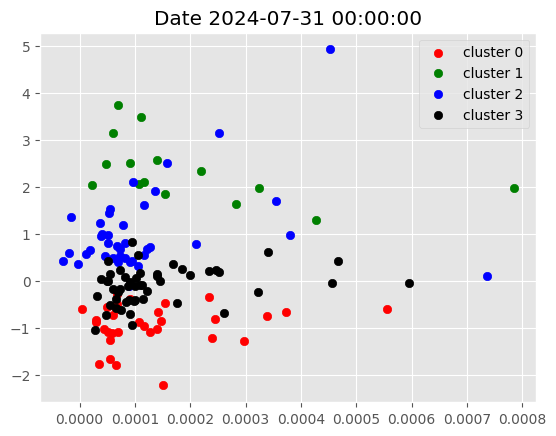

In [47]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

## For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization 
- first filter only stocks corresponding to the cluster we choose based on hypothesis
- momentum is persistent and my idea is that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3 

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

## Visualize Portfolio returns and compare to SP500 returns

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
